In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from qutip import *

import qutip_qip
from qutip_qip.circuit import QubitCircuit
from qutip.qip.operations import *
from qutip.qip.operations.gates import *
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor, Processor
from qutip_qip.noise import Noise
from qutip.qip.noise import RandomNoise # for Gaussian noise
from qutip.qip.pulse import Pulse
from qutip.qip.gates import *
import matplotlib.pyplot as plt
from qutip import (Qobj, Options, basis, fock_dm, qeye, sigmax, sigmay, sigmaz, tensor)
from qutip_qip.operations import Gate

import scipy
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

import functools # for reduce
from joblib import Parallel, delayed  # for parallel simulations
import itertools # for RB inverse search

import os
import os.path

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_17548\4269414032.py:17: DeprecationWarning: Importation from qutip.qip.gates is deprecated.Please use e.g.
 from qutip.qip.operations import cnot

  from qutip.qip.gates import *


In [2]:
class MyProcessor(ModelProcessor):
    """
    Custom processor built using ModelProcessor as the base class.
    This custom processor will inherit all the methods of the base class
    such as setting up of the T1 and T2 decoherence rates in the simulations.

    Args:
        num_qubits (int): Number of qubits in the processor.
        t1, t2 (float or list): The T1 and T2 decoherence rates for the
    """

    def __init__(self, num_qubits, t1=None, t2=None):
        # call the parent class initializer
        super(MyProcessor, self).__init__(num_qubits, t1=t1, t2=t2)  
        # The control pulse is discrete or continous.
        self.pulse_mode = "discrete"
        # The dimension of each controllable quantum system
        self.model.dims = [2] * num_qubits
        self.num_qubits = num_qubits
        self.set_up_ops()  # set up the available Hamiltonians

    def set_up_ops(self):
        """
        Sets up the control operators.
        """
        # sigmax pulse on m-th qubit with the corresponding pulse
        for m in range(self.num_qubits):
            self.add_control(1/2*sigmax(), m, label="sx" + str(m))
        # sy
        for m in range(self.num_qubits):
            self.add_control(1/2*sigmay(), m, label="sy" + str(m))
    
    # To remove some errors
    def add_noise(self, noise):
        """
        Add a noise object to the processor

        Parameters
        ----------
        noise: :class:`.Noise`
            The noise object defined outside the processor
        """
        self.noise.append(noise)


In [3]:
class MyCompiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using
    the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "ROT": self.rotation_with_phase_compiler,
            "RX": self.single_qubit_gate_compiler,
            "RY": self.single_qubit_gate_compiler,
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), np.cos(phase) * coeff),
            ("sy" + str(gate.targets[0]), np.sin(phase) * coeff),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def single_qubit_gate_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the rotation angle
        _step_list = np.linspace(0,1,11)
        tlist = np.abs(gate.arg_value) / self.params["pulse_amplitude"] * _step_list
        coeff = self.params["pulse_amplitude"] * np.sign(gate.arg_value) * (_step_list[:-1] *0 + 1)
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist, coeff, phase=0.0)
        elif gate.name == "RY":
            return self.generate_pulse(gate, tlist, coeff, phase=np.pi / 2)

    def rotation_with_phase_compiler(self, gate, args):
        """Compiles gates with a phase term.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the pulse phase
        _step_list = np.linspace(0,1,11)
        tlist = self.params["duration"] * _step_list
        coeff = self.params["pulse_amplitude"] * (_step_list[:-1] *0 + 1)
        return self.generate_pulse(gate, tlist, coeff, phase=gate.arg_value)

## Dynamical Decoupling

### ZZ crosstalk

In [4]:
def list_extension(n, list):
    new_list = []
    for i in range(len(list)):
        new_list.append(list[i])
        if i < len(list)-1:
            for j in range(n)[1:]:
                new_list.append(j/n * (list[i+1] - list[i])+ list[i])
    return new_list

In [21]:
class ZZ_crosstalk(Noise):
    def __init__(self, strength):
        self.strength = strength

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        zz_operator = tensor([sigmaz(), sigmaz()])
        for i in range(len(dims) - 1):
            systematic_noise.add_control_noise(self.strength * zz_operator, targets=[i, i + 1], tlist=tlist, coeff=True)

crosstalk_noise = ZZ_crosstalk(strength=0.1)

In [26]:
# Define a circuit and run the simulation
num_qubits = 3

circuit = QubitCircuit(num_qubits)
circuit.add_gate(Gate("RY", targets = 0, arg_value=1/4))
circuit.add_gate(Gate("RX", targets = 0, arg_value=1/2))

myprocessor = MyProcessor(num_qubits)
myprocessor.native_gates = None
mycompiler = MyCompiler(num_qubits, {"pulse_amplitude": 1})

myprocessor.load_circuit(circuit, compiler=mycompiler)
gaussnoise = RandomNoise(dt=0.01,indices = [0,1], rand_gen=np.random.normal, loc=0, scale=0.03)
myprocessor.add_noise(crosstalk_noise)

The Evolution element went wrong was
 {'qobj': Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.1  0.   0.   0. ]
 [ 0.  -0.1  0.   0. ]
 [ 0.   0.  -0.1  0. ]
 [ 0.   0.   0.   0.1]], 'targets': [0, 1], 'tlist': {'sx0': array([0.        , 0.31415927, 0.62831853, 0.9424778 , 1.25663706,
       1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
       3.14159265]), 'sy0': array([0.        , 0.31415927, 0.62831853, 0.9424778 , 1.25663706,
       1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
       3.14159265])}, 'coeff': True}


TypeError: Incorrect Q_object specification

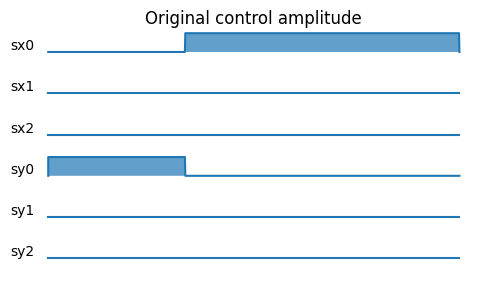

In [27]:
# Plot the ideal pulse
myprocessor.plot_pulses(title="Original control amplitude", figsize=(5,3), rescale_pulse_coeffs = False)

# Plot the noisy pulse
qobjevo, _ = myprocessor.get_qobjevo(noisy=True)
noisy_coeff0 = qobjevo.to_list()[1][1] + qobjevo.to_list()[2][1]
#noisy_coeff1 = qobjevo.to_list()[3][1] + qobjevo.to_list()[4][1]
fig2, axis2 = myprocessor.plot_pulses(title="Noisy control amplitude", figsize=(5,3), rescale_pulse_coeffs = False)
axis2[0].step(qobjevo.tlist, noisy_coeff0)
#axis2[1].step(qobjevo.tlist, noisy_coeff1)